# CIFAR 100 분류기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import gc

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

import wandb
from sklearn.metrics import accuracy_score

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)
random_seed(42)

In [3]:
device = torch.device('mps')

In [4]:
#wandb.login(key='')

# Data

In [4]:
cifar_transforms = T.Compose([
    T.ToTensor()
])

download_root = './CIFAR100_DATASET'

train_dataset = torchvision.datasets.CIFAR100(download_root, transform=cifar_transforms, train=True, download=True)
test_dataset = torchvision.datasets.CIFAR100(download_root, transform=cifar_transforms, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(train_dataset)

50000

In [6]:
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

40000
10000
10000


In [7]:
batch_size = 100

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

In [8]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

# Model
- ResNet 형식으로 구현

In [9]:
class BottleNeck(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, mul=4):
        super().__init__()

        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),  # 1 x 1 conv: (c_in, n, n) -> (c_out, n, n)
            torch.nn.BatchNorm2d(num_features=out_channels),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1,bias=False), # 3 x 3 conv: (c_out, n, n) -> (c_out, n, n)
            torch.nn.BatchNorm2d(num_features=out_channels),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(out_channels, out_channels*mul, kernel_size=1, stride=1, bias=False) # 1 x 1 conv: (c_out, n, n) -> (c_out*mul, n, n)
        )

        self.shorcut = torch.nn.Sequential()

        if stride != 1 or in_channels != out_channels*mul:
            self.shorcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels*mul, kernel_size=1, stride=stride, bias=False), # 1 x 1 conv
                torch.nn.BatchNorm2d(num_features=out_channels*mul)
            )

        self.relu = torch.nn.ReLU(True)

    def forward(self, x):
        out = self.relu(self.layer(x) + self.shorcut(x))
        return out
    
class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.pre_conv_layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )

        self.bottle_neck_1 = self.make_bottle_neck(in_channels=16, out_channels=16, stride=1, mul=2)
        self.bottle_neck_2 = self.make_bottle_neck(in_channels=32, out_channels=64, stride=1, mul=1)
        self.bottle_neck_3 = self.make_bottle_neck(in_channels=64, out_channels=128, stride=2, mul=1)
        self.bottle_neck_4 = self.make_bottle_neck(in_channels=128, out_channels=128, stride=2, mul=2)

        
        self.post_linear_layer = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=256*8*8, out_features=2048),
            torch.nn.BatchNorm1d(num_features=2048),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(in_features=2048, out_features=512),
            torch.nn.BatchNorm1d(num_features=512),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(in_features=512, out_features=100),
            torch.nn.LogSoftmax(dim=1)
        )

    def make_bottle_neck(self, in_channels, out_channels, stride=1, mul=1):
        return BottleNeck(in_channels, out_channels, stride, mul)

    def forward(self, x):
        x = self.pre_conv_layer(x)
        x = self.bottle_neck_1(x)
        x = self.bottle_neck_2(x)
        x = self.bottle_neck_3(x)
        x = self.bottle_neck_4(x)
        output = self.post_linear_layer(x)
        return output

In [10]:
model_tmp = ResNet()
summary(model_tmp, input_size=(3, 32, 32))

del model_tmp
gc.collect()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             256
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]             512
           Conv2d-12           [-1, 32, 32, 32]             512
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

0

# train

In [11]:
#run = wandb.init(project='CIFAR100', name='train')

In [11]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (labels == predicted).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        #monitoring_values = {'Train Loss': train_loss, 'Train Accuracy': train_accuracy, 'Valid Loss': valid_loss, 'Valid Accuracy': valid_accuracy}
        #run.log(monitoring_values, step=epoch)

    return model

In [12]:
model = ResNet()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader ,valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [24]:
run.finish()

Train Accuracy,▁▃▄▆██████
Train Loss,█▆▄▃▂▁▁▁▁▁
Valid Accuracy,▁▇██▇█████
Valid Loss,█▂▁▁▂▂▂▂▂▂
Train Accuracy,0.99965
Train Loss,0.00952
Valid Accuracy,0.3934
Valid Loss,2.71761


# test
## 결과
- 정확도: 약 39%
- 오버피팅 발생

In [25]:
test_loss = 0.0
test_accuracy = 0
total_images = []
total_labels = []
total_predicted = []

model.to(device)
model.eval()

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        total_images.extend(images)
        total_labels.extend(labels)
        total_predicted.extend(predicted)

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(test_loss, test_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

2.733834433555603 0.3933


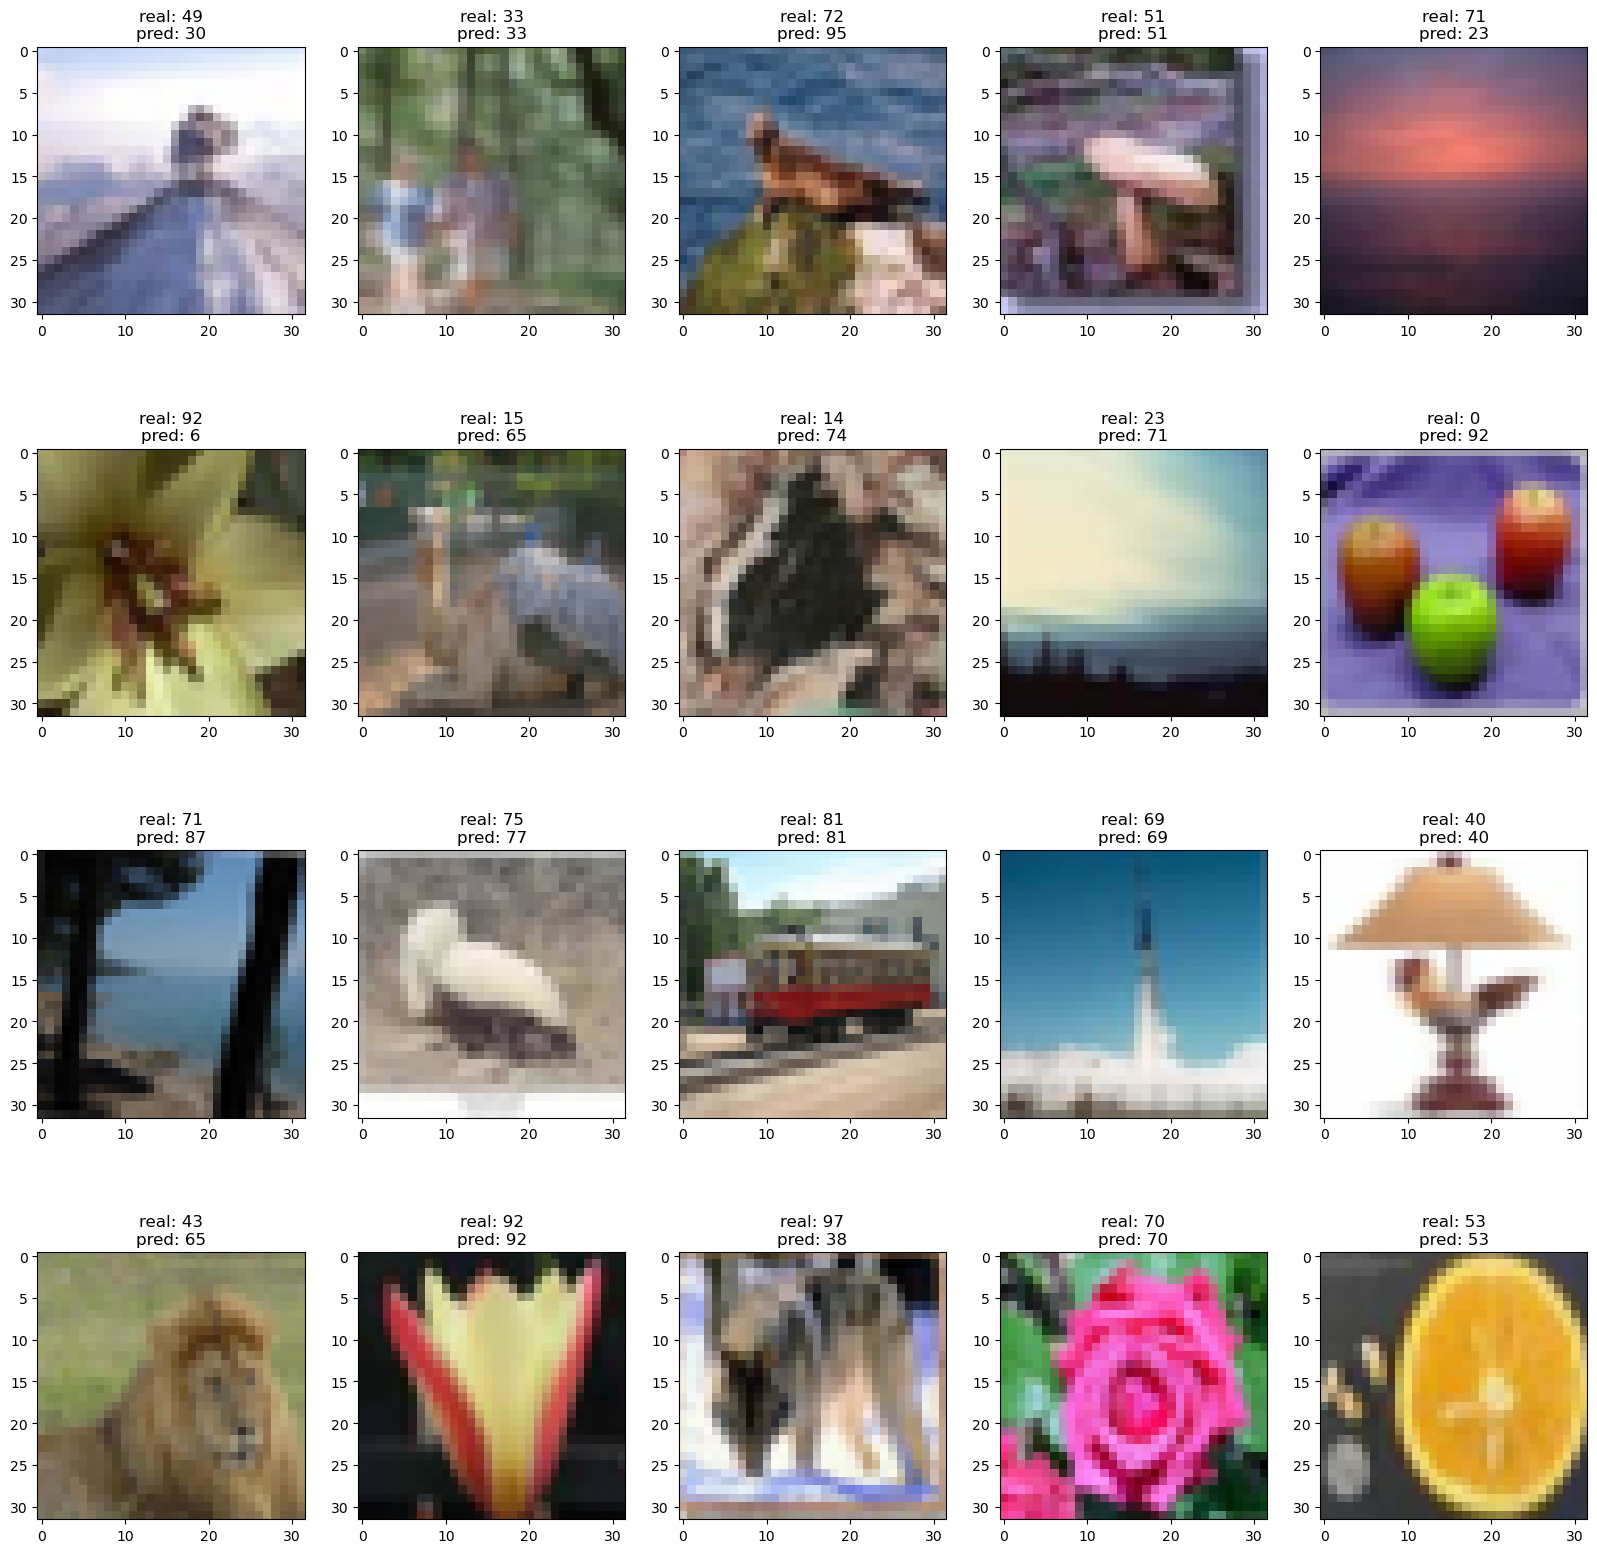

In [26]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_images[i].cpu().permute((1, 2, 0))))
    plt.title(f'real: {total_labels[i].cpu()}\npred: {total_predicted[i].cpu()}')

# overfitting 확인

In [29]:
test_loss = 0.0
test_accuracy = 0
total_images = []
total_labels = []
total_predicted = []

model.to(device)
model.eval()

with torch.no_grad():
    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        total_images.extend(images)
        total_labels.extend(labels)
        total_predicted.extend(predicted)

test_loss = test_loss / len(train_dataloader)
test_accuracy = test_accuracy / len(train_dataset)

print(test_loss, test_accuracy)

# 결과를 통해 과적합 되었다는 것을 알 수 있다.

  0%|          | 0/40 [00:00<?, ?it/s]

0.002223142021102831 0.999825


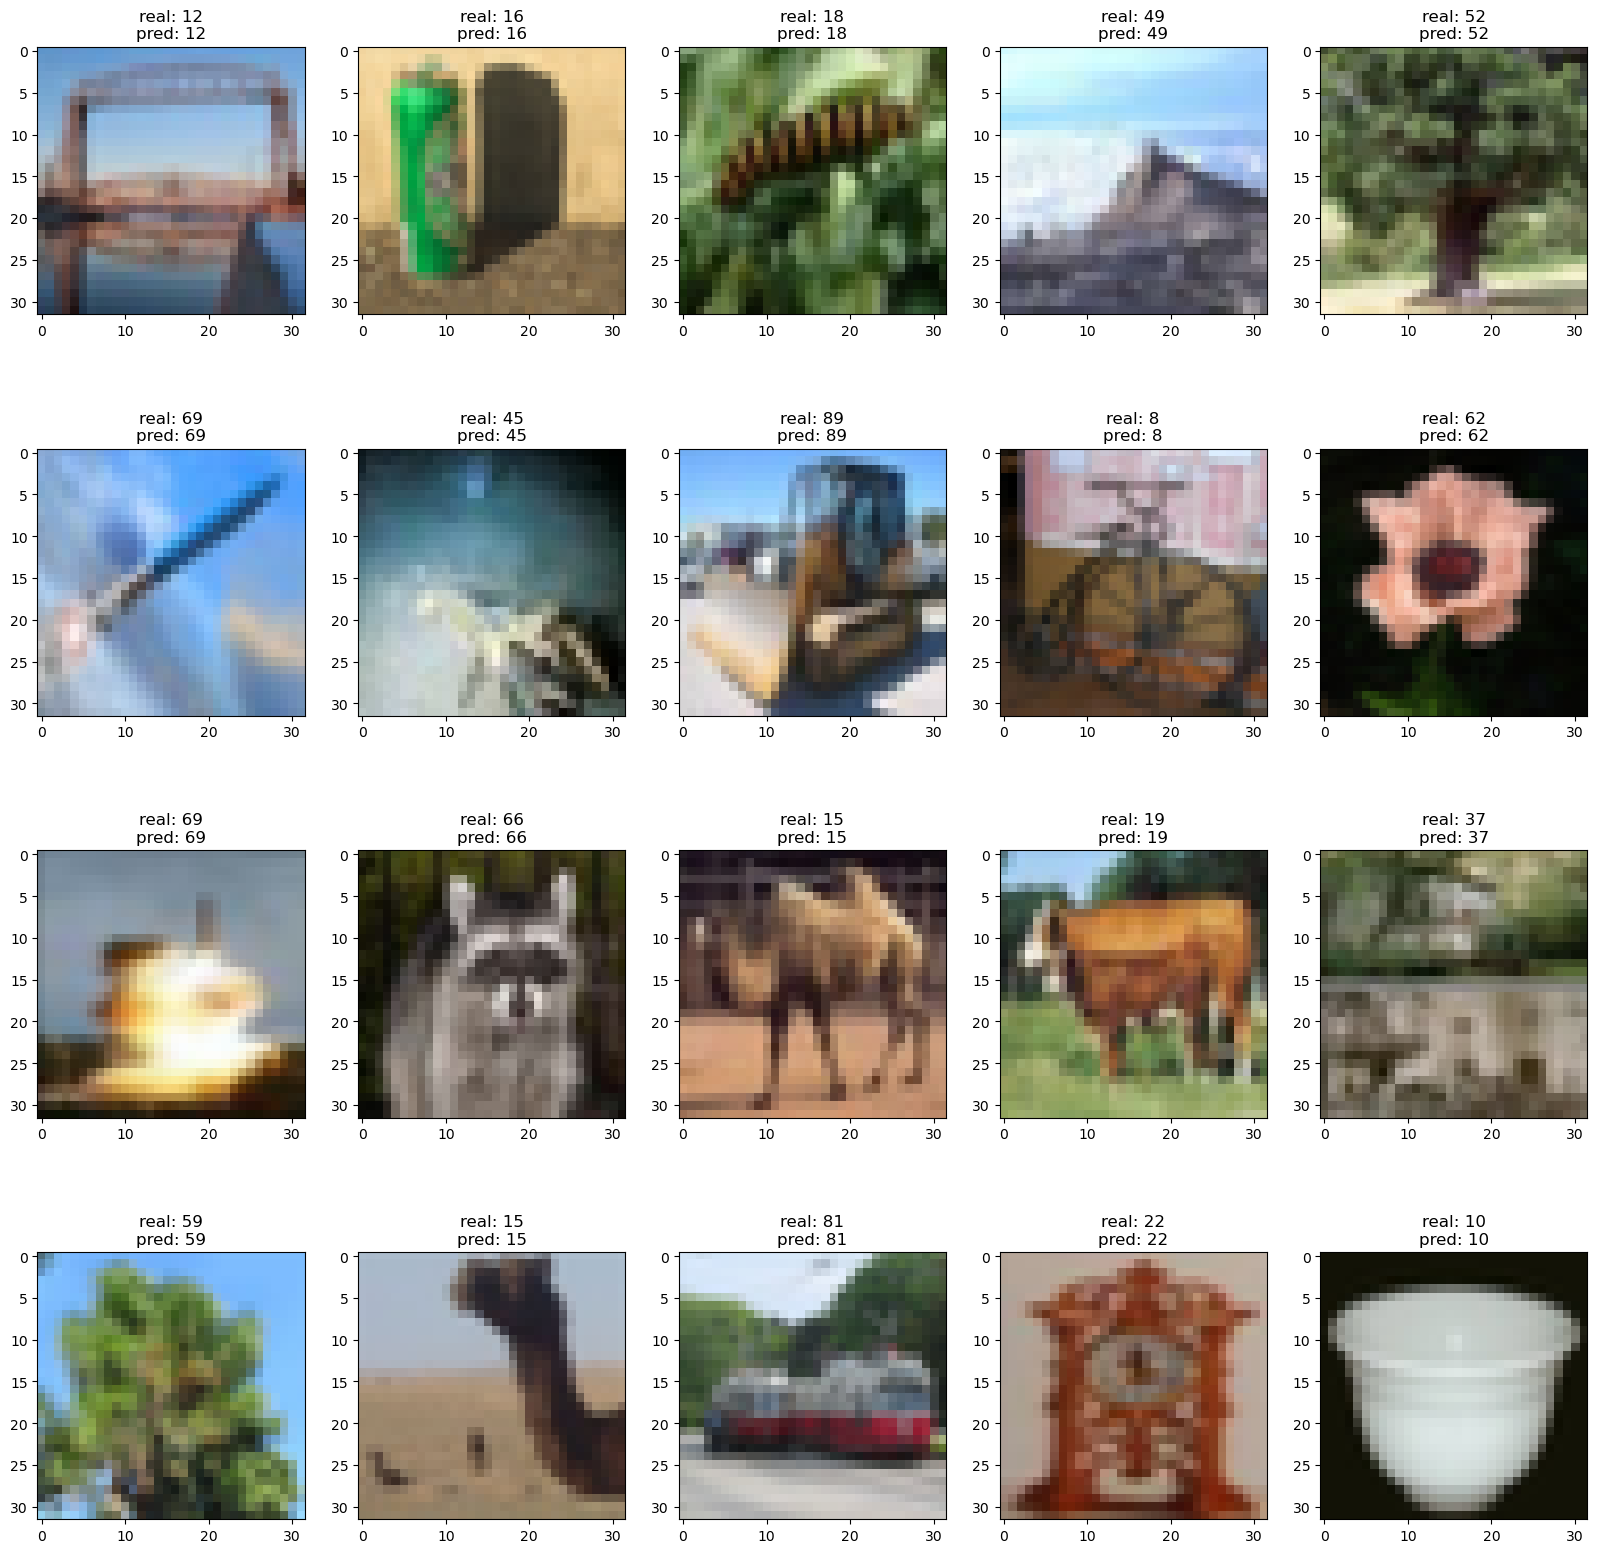

In [30]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_images[i].cpu().permute((1, 2, 0))))
    plt.title(f'real: {total_labels[i].cpu()}\npred: {total_predicted[i].cpu()}')

# 정확도 향상을 위한 시도
1. 학습량을 증가 -> 오히려 과적합 발생할 것 -> 시도 x
2. 이미지 증강 사용
3. 간단한 모델 생성
4. 더 깊이가 깊은 모델 생성

# 2. 이미지 증강 사용
## 결과
- 오버피팅은 방지됨
- 정확도: 약 45%
- 정확도 소폭 상승

In [8]:
cifar_transforms = T.Compose([
    T.ToTensor()
])

aug_cifar_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(45), # 이미지를 무작위로 회전한다.
    T.RandomResizedCrop(size=(32, 32), scale=(0.7, 1.0)), # 이미지를 랜덤한 크기로 자르고 리사이즈한다.
    T.RandomHorizontalFlip(p=0.5), # 이미지를 수평으로 뒤집는다.
    T.RandomVerticalFlip(p=0.5), # 이미지를 수직으로 뒤집는다.
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1), # 이미지의 밝기, 대조, 채도, 색조를 랜덤하게 조정한다.
])

download_root = './CIFAR100_DATASET'

aug_train_dataset = torchvision.datasets.CIFAR100(download_root, transform=aug_cifar_transforms, train=True, download=True)
origin_train_dataset = torchvision.datasets.CIFAR100(download_root, transform=cifar_transforms, train=True, download=False)
test_dataset = torchvision.datasets.CIFAR100(download_root, transform=cifar_transforms, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


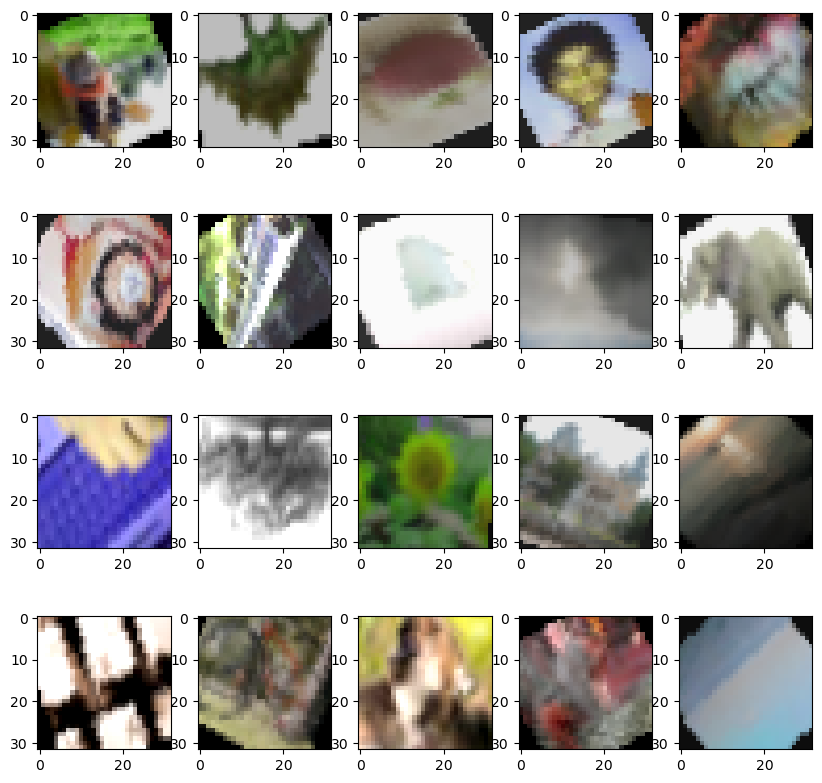

In [10]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(aug_train_dataset[i][0].permute((1, 2, 0))))

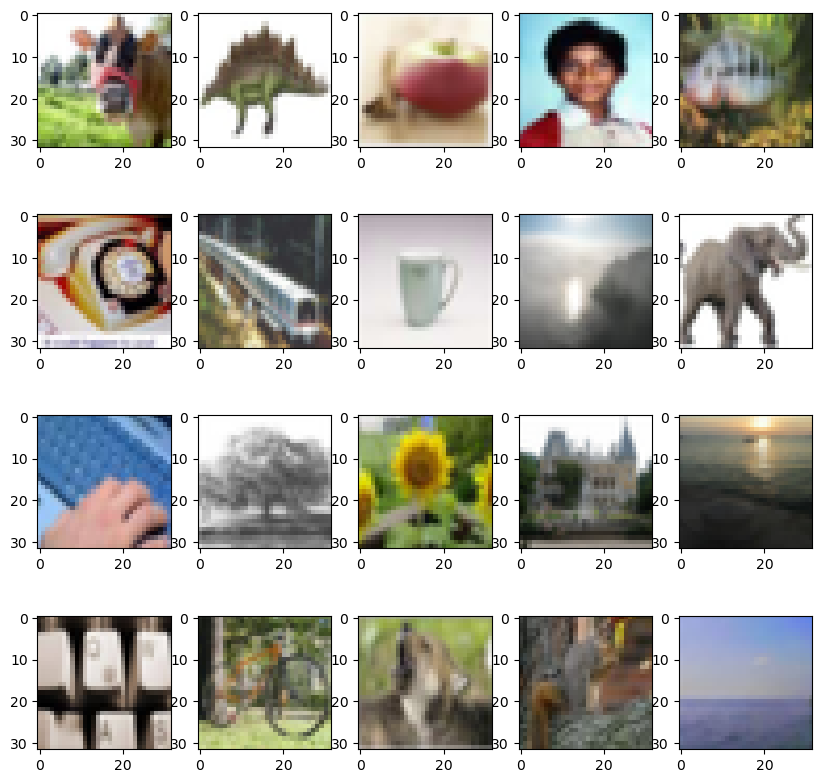

In [11]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(origin_train_dataset[i][0].permute((1, 2, 0))))

In [12]:
train_dataset = torch.utils.data.ConcatDataset([origin_train_dataset, aug_train_dataset])

In [13]:
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

In [14]:
batch_size = 1000
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 학습

In [15]:
run = wandb.init(project='CIFAR100', name='aug_train')

In [16]:
model = ResNet()
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader ,valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10, run)

  0%|          | 0/80 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
run.finish()

Train Accuracy,▁▃▄▅▆▇▇███
Train Loss,█▆▅▄▃▂▂▁▁▁
Valid Accuracy,▁▄▅▆▇▇▇███
Valid Loss,█▅▃▃▂▂▁▁▁▁
Train Accuracy,0.62725
Train Loss,1.517
Valid Accuracy,0.3859
Valid Loss,2.46975


In [18]:
test_loss = 0.0
test_accuracy = 0
total_images = []
total_labels = []
total_predicted = []

model.to(device)
model.eval()

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        total_images.extend(images)
        total_labels.extend(labels)
        total_predicted.extend(predicted)

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(test_loss, test_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

2.2732428073883058 0.4521


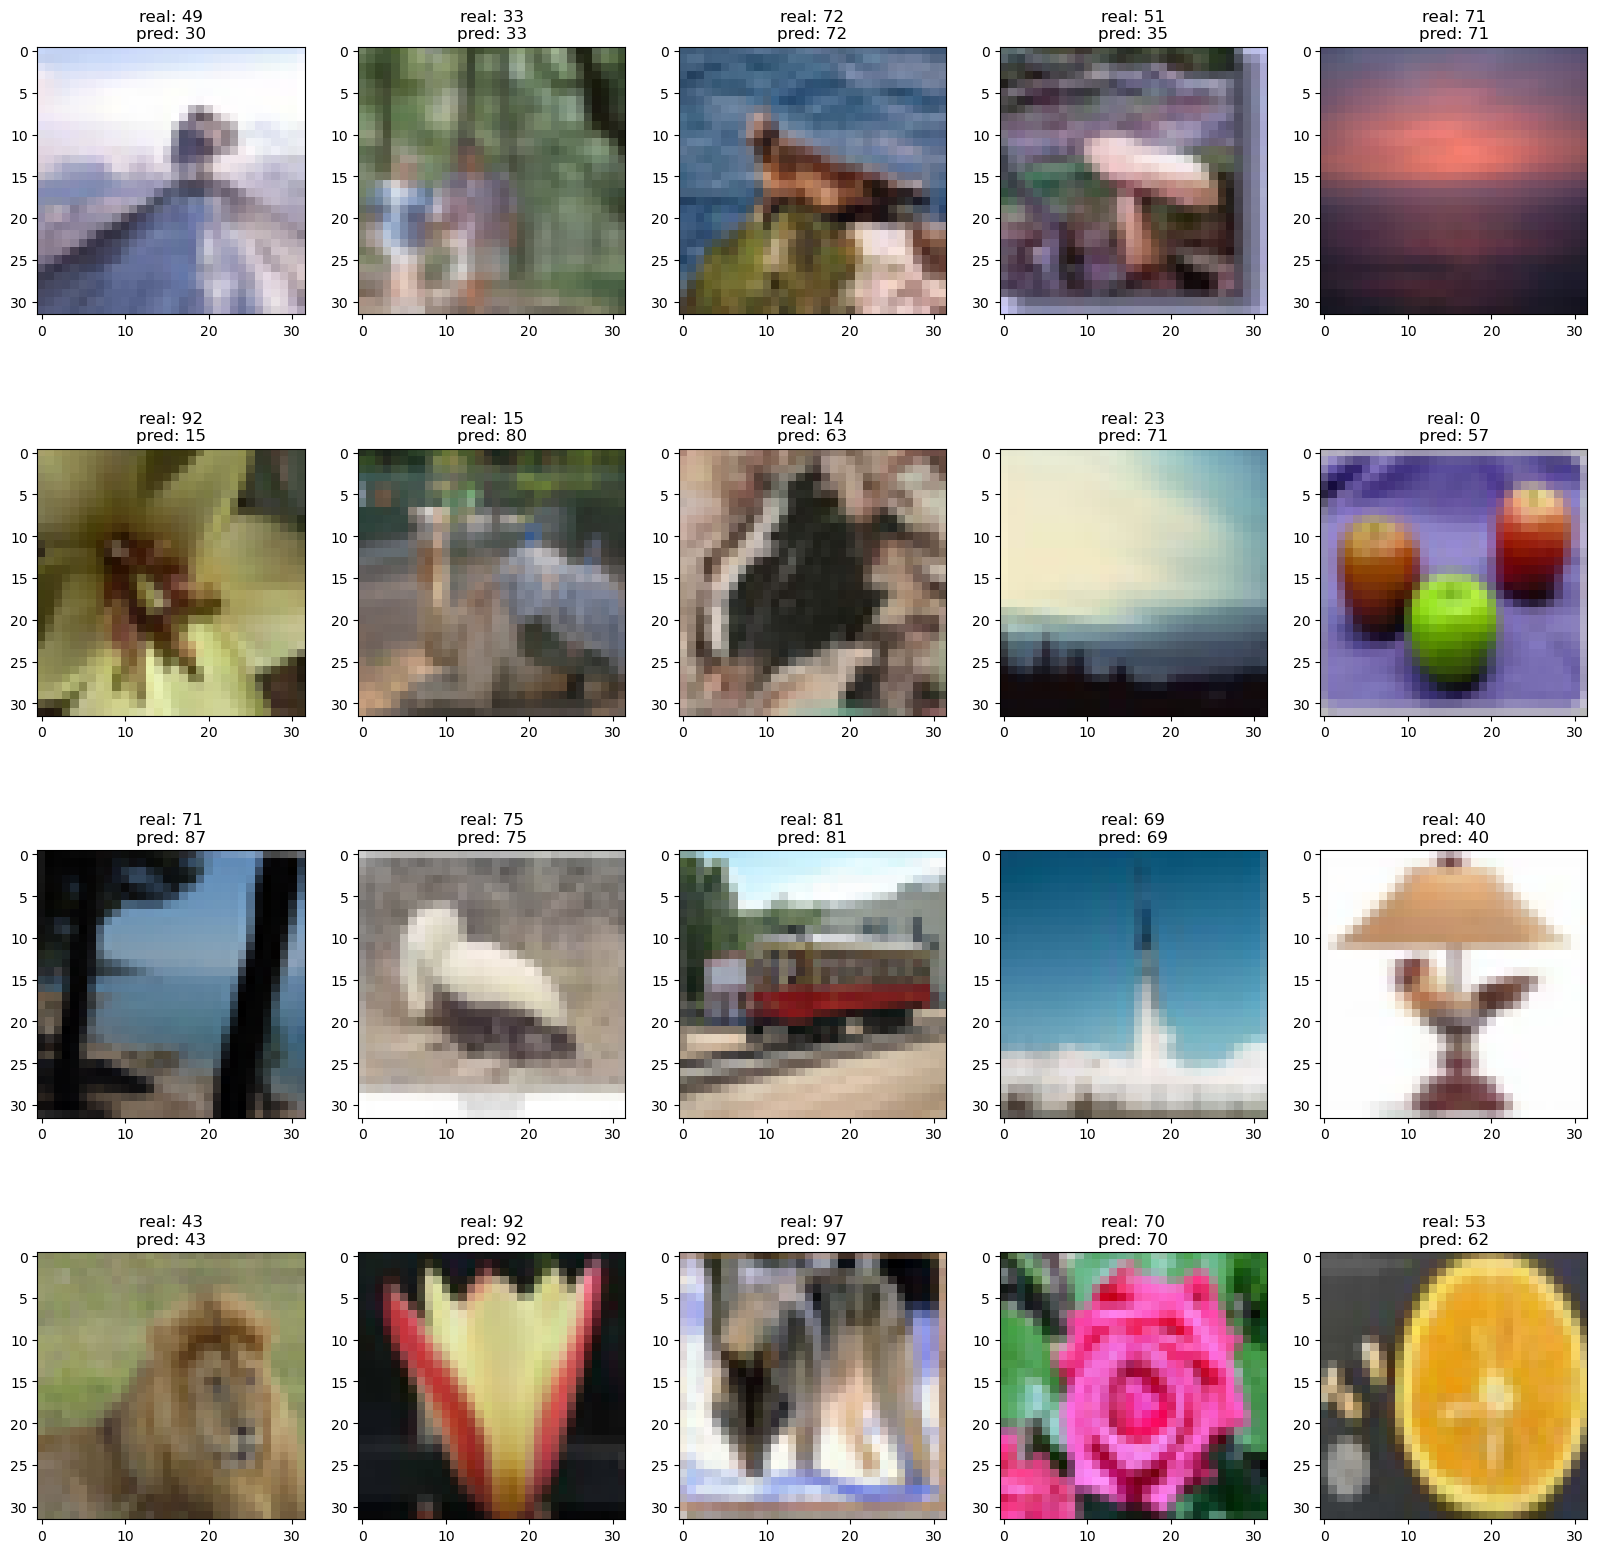

In [19]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_images[i].cpu().permute((1, 2, 0))))
    plt.title(f'real: {total_labels[i].cpu()}\npred: {total_predicted[i].cpu()}')

# 3. 간단한 모델 생성
## 결과
- 정확도 향상 없음
- epoch를 늘렸을 때 valid, test 정확도는 유지 but 과적합 발생

In [11]:
class simple_CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=8*8*64, out_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=512),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=512, out_features=100),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        outputs = self.layer(x)
        return outputs

## 학습

In [14]:
run = wandb.init(project='CIFAR100', name='simple_model_train')

model = simple_CNN()
print(summary(model, input_size=(3, 32, 32)))
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 20, run)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                 [-

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
run.finish()

Train Accuracy,▁▃▄▅▅▆▆▇▇█
Train Loss,█▆▅▄▃▃▂▂▁▁
Valid Accuracy,▁▅▆▆▇▇▇▇██
Valid Loss,█▄▂▂▂▂▂▂▁▂
Train Accuracy,0.6862
Train Loss,1.11799
Valid Accuracy,0.4099
Valid Loss,2.45287


In [15]:
test_loss = 0.0
test_accuracy = 0
total_images = []
total_labels = []
total_predicted = []

model.to(device)
model.eval()

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        total_images.extend(images)
        total_labels.extend(labels)
        total_predicted.extend(predicted)

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(test_loss, test_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

3.4102608442306517 0.4478


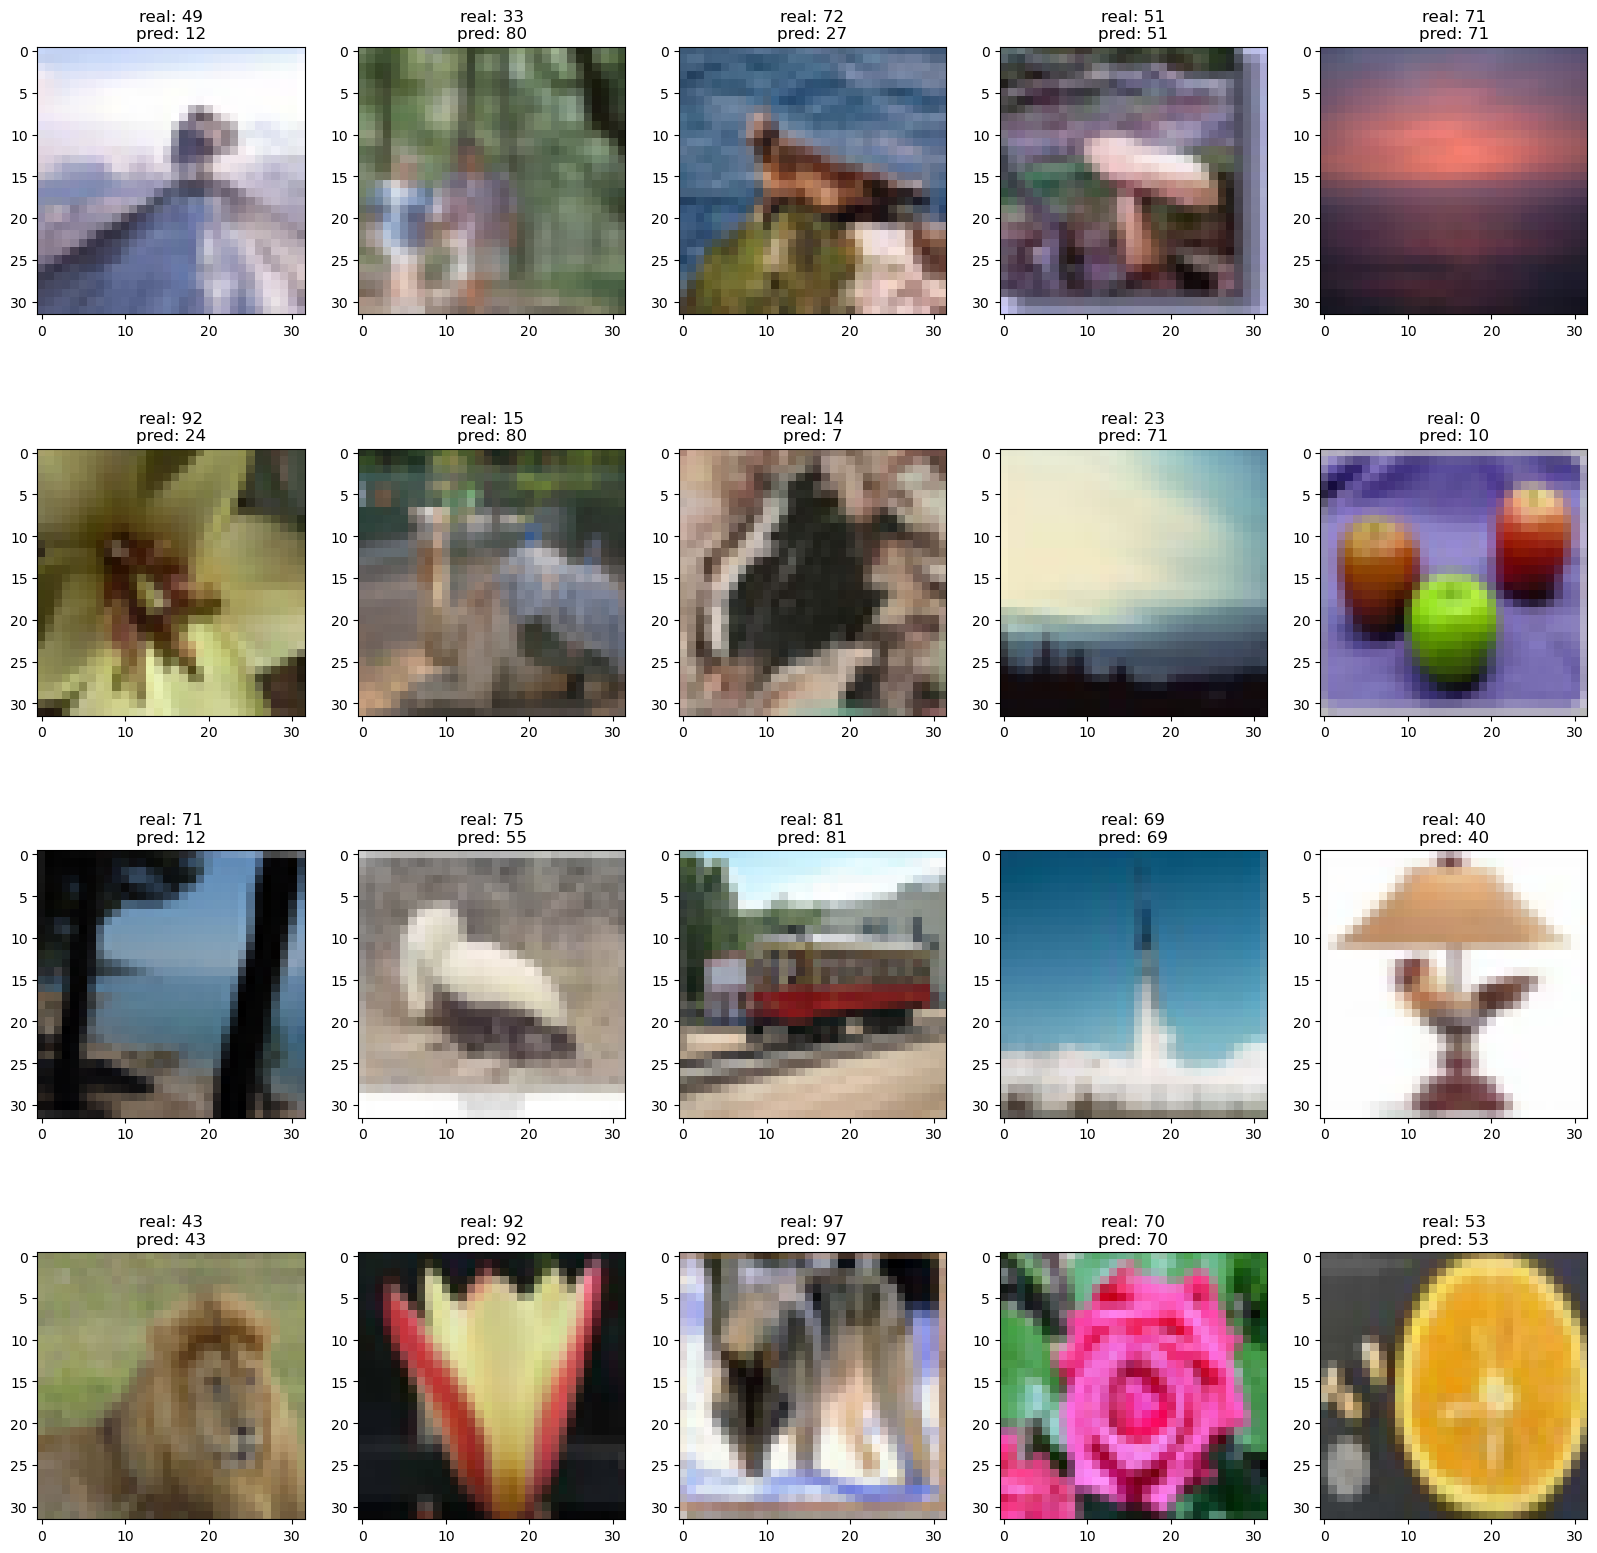

In [16]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_images[i].cpu().permute((1, 2, 0))))
    plt.title(f'real: {total_labels[i].cpu()}\npred: {total_predicted[i].cpu()}')

## overfitting 확인

In [17]:
test_loss = 0.0
test_accuracy = 0
total_images = []
total_labels = []
total_predicted = []

model.to(device)
model.eval()

with torch.no_grad():
    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_accuracy += (predicted == labels).sum().item()

        total_images.extend(images)
        total_labels.extend(labels)
        total_predicted.extend(predicted)

test_loss = test_loss / len(train_dataloader)
test_accuracy = test_accuracy / len(train_dataset)

print(test_loss, test_accuracy)

# 결과를 통해 과적합 되었다는 것을 알 수 있다.

  0%|          | 0/40 [00:00<?, ?it/s]

0.027333852974697946 0.9991


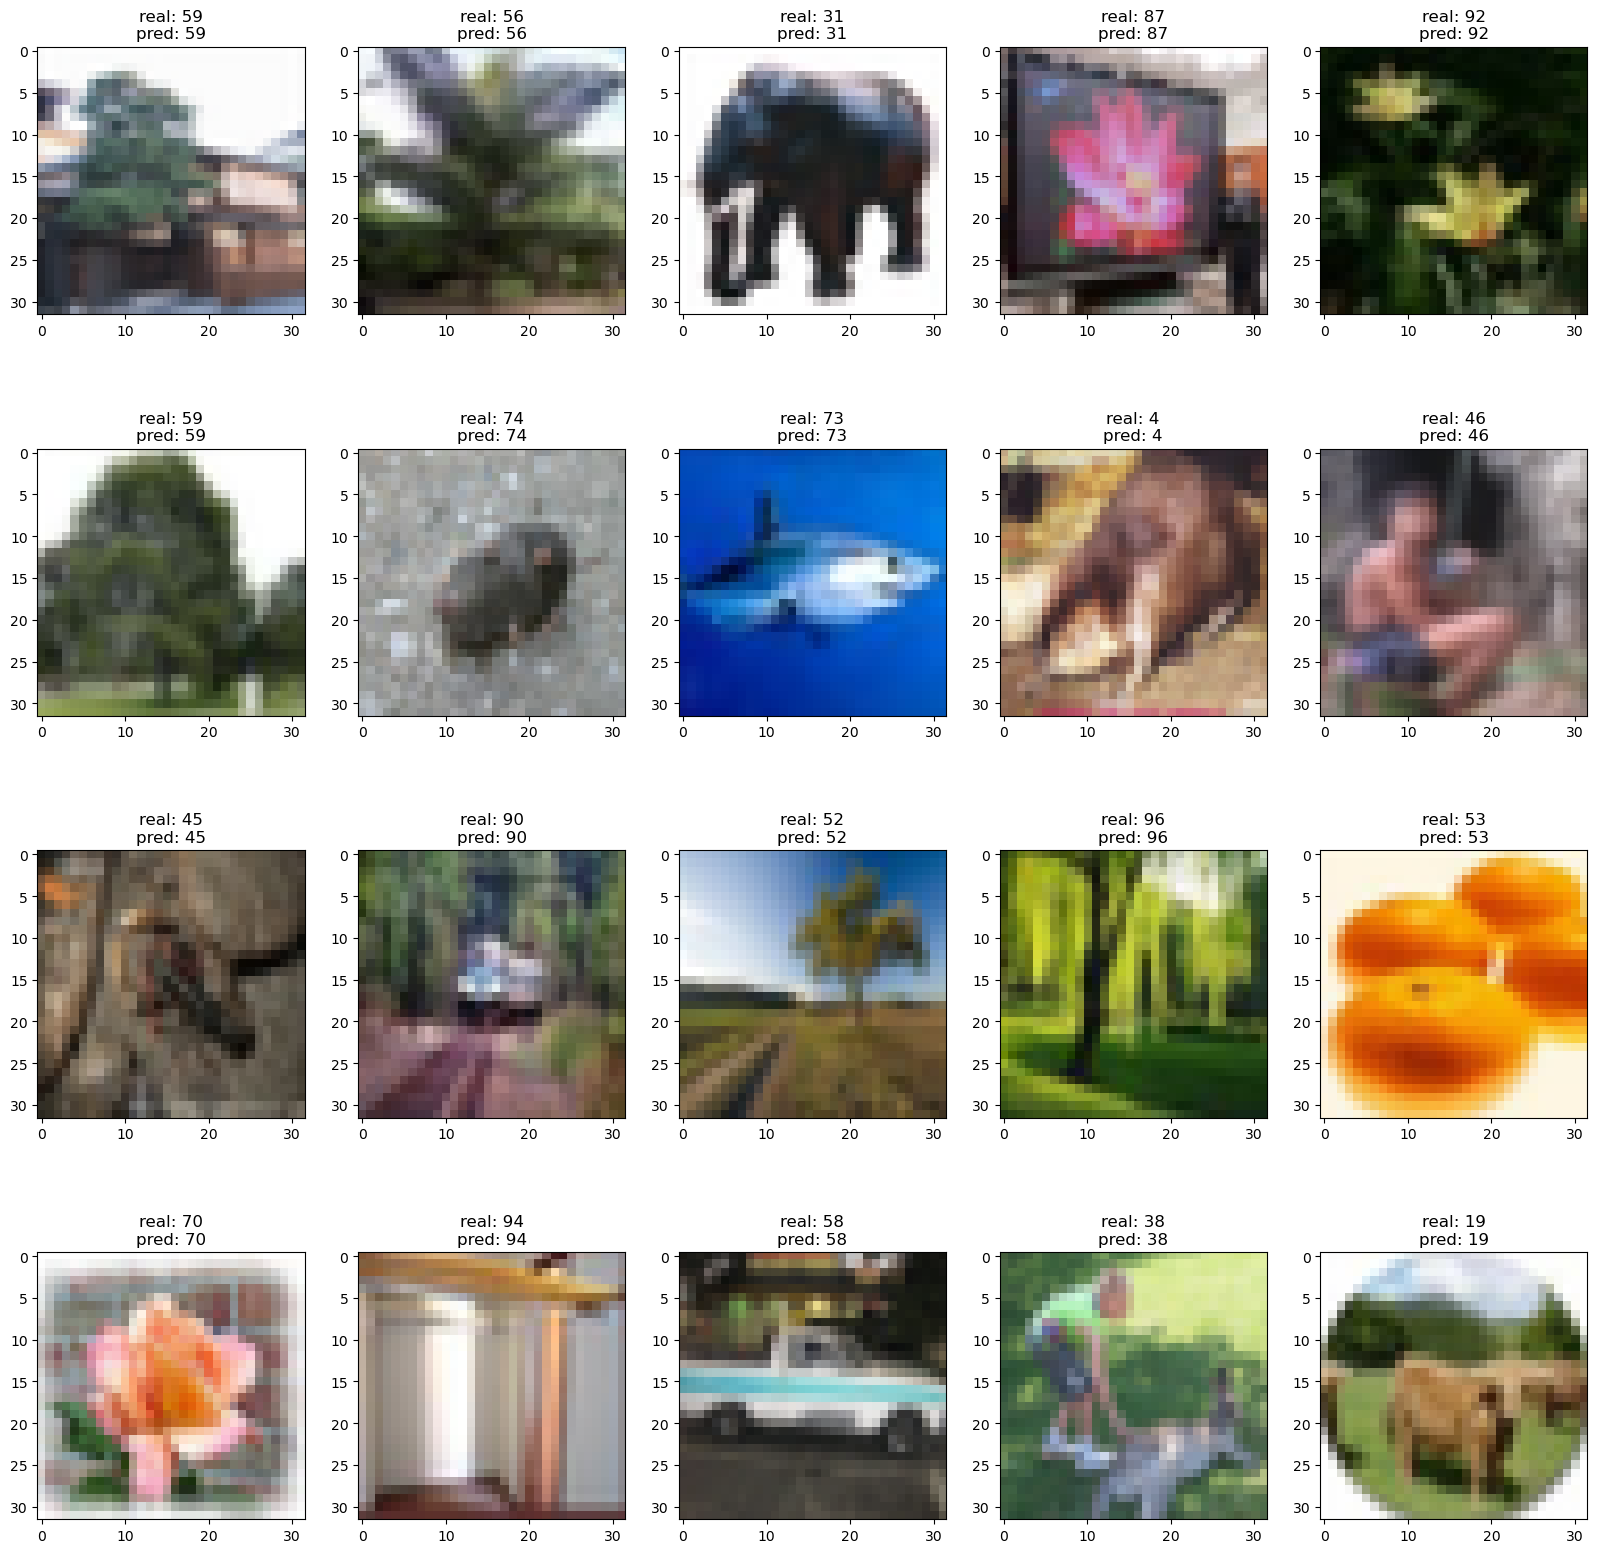

In [18]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_images[i].cpu().permute((1, 2, 0))))
    plt.title(f'real: {total_labels[i].cpu()}\npred: {total_predicted[i].cpu()}')